In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/PBL-SecondSemester/DeepLearning/DataSet'

import os
import cv2

import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
import random

from keras.preprocessing.image import ImageDataGenerator

!pip install patchify --quiet
from patchify import patchify, unpatchify
import tifffile as tiff

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1LFMENSUeZANGJsWPtbb3BcvK4y9YdVWF/PBL-SecondSemester/DeepLearning/DataSet


In [14]:
def resize_images( input_images, x, y, z ):

  input_images = np.array( input_images )

  size = len( input_images )
  dim = (x, y)

  output_images = []

  for i in range(0, size):
    img = input_images[i]
    img = cv2.resize(img, dim, interpolation= cv2.INTER_LINEAR)
    if z == 1: img = img[:, :, 0]
    output_images.append( img )

  output_images = np.array( output_images )
  
  return output_images

files = os.listdir( "Txarrak" )
files = sorted(files)

wrong_img = []
wrong_roi = []

for file in files:
  img = cv2.imread( "Txarrak/" + file )

  if file.endswith("_ROI.bmp"):
    wrong_roi.append( img )
  else:
    wrong_img.append( img )

img_size = 640

wrong_img = np.array( resize_images( wrong_img, img_size, img_size, 0 ), dtype = 'int16' )

img = []
for i in range(0, len(wrong_roi)):
  img.append( cv2.cvtColor(wrong_roi[i], cv2.COLOR_BGR2GRAY) )
wrong_roi = np.array( resize_images( img, img_size, img_size, 0 ), dtype = ('int16') )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


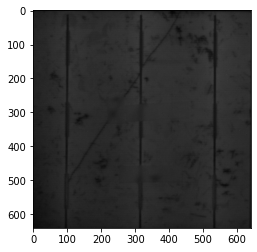

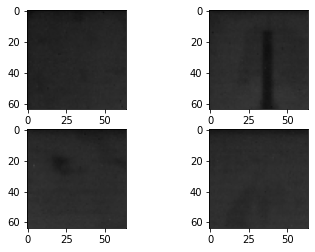

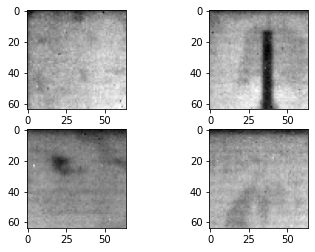

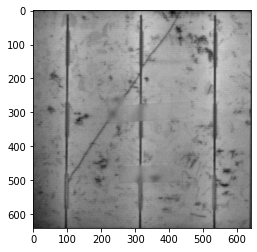

In [15]:
index = random.randint(0, len(wrong_img) - 1)
index = 52

img_in = wrong_img[index]

#################################################################################

# Define internal parameters
crop_size = 64

# Calculate parameters
img_size = img_in.shape[0]
crop = int(img_size / crop_size)
crops = int( pow(crop, 2) )

# Generate patchs
patch = patchify(img_in[:, :, 0], (64, 64), step = 64)

# Define model input array 
dec = np.zeros( (crops, 64, 64, 3), dtype = img_in.dtype )

# Format change
for i in range( crop ):
  for j in range( crop ):
    n = i * crop + j
    for channel in range( 3 ):
      dec[n, :, :, channel] = patch[i, j, :, :]

##### MODEL #####
img = dec
img = img[:, :, :, 0] / 255
result = img * 255
#################

# Define output image
rec = np.zeros( (img_in.shape[0], img_in.shape[1]), dtype = img_in.dtype )

# Reconstruct image
n = 0

for i in range( crop ):
  for j in range( crop ):

    x1 = i * crop_size
    x2 = (i + 1) * crop_size

    y1 = j * crop_size
    y2 = (j + 1) * crop_size

    rec[x1:x2 , y1:y2] = result[n]
    n = n + 1

#################################################################################


plt.imshow( img_in )
plt.show()

print("=================================================")

plt.subplot(221)
plt.imshow( dec[0] )
plt.subplot(222)
plt.imshow( dec[1] )
plt.subplot(223)
plt.imshow( dec[2] )
plt.subplot(224)
plt.imshow( dec[3] )
plt.show()

print("=================================================")

plt.subplot(221)
plt.imshow( result[0], cmap = "gray" )
plt.subplot(222)
plt.imshow( result[1], cmap = "gray" )
plt.subplot(223)
plt.imshow( result[2], cmap = "gray" )
plt.subplot(224)
plt.imshow( result[3], cmap = "gray" )
plt.show()

print("=================================================")

plt.imshow( rec, cmap = "gray" )
plt.show()

In [16]:
def make_prediction (img_in, model):

  # Define internal parameters
  crop_size = 64

  # Calculate parameters
  img_size = img_in.shape[0]
  crop = int(img_size / crop_size)
  crops = int( pow(crop, 2) )

  # Generate patchs
  patch = patchify(img_in[:, :, 0], (64, 64), step = 64)

  # Define model input array 
  dec = np.zeros( (crops, 64, 64, 3), dtype = img_in.dtype )

  # Format change
  for i in range( crop ):
    for j in range( crop ):
      n = i * crop + j
      for channel in range( 3 ):
        dec[n, :, :, channel] = patch[i, j, :, :]

  ##### MODEL #####
  result = model.predict( dec )
  #################

  # Define output image
  rec = np.zeros( (img_in.shape[0], img_in.shape[1], 1), dtype = img_in.dtype )

  # Reconstruct image
  n = 0

  for i in range( crop ):
    for j in range( crop ):

      x1 = i * crop_size
      x2 = (i + 1) * crop_size

      y1 = j * crop_size
      y2 = (j + 1) * crop_size

      rec[x1:x2 , y1:y2] = result[n]
      n = n + 1

  # Channels problem
  rec = rec[:, :, 0]

  return rec